# Illustrate the iEGM through the Buffer-Stock Model

## Monte Carlo Settings

In [1]:
MC_num = 200 # number of Monte Carlo simulations
C_num_grid = (20,50,100,200) # number of grid points in consumption grid i iEGM
specs = { # common specifications across methods
    # 'rho':1.5,      # constant relative risk aversion coefficient

    'num_m':100,    # number of points in the single state: normalized resources
    'max_m':5.0,    # maximum level of normalized resources

    'max_C':10.0,   # maximum level of consumption in iEGM precomputation

    'T': 20,        # number of periods
    'simN':10_000,  # number of agents in simulation

} 

## Load relevant packages

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from time import time
import matplotlib.pyplot as plt
from UnitaryModel import UnitaryModelClass

plt.rcParams.update({'font.size': 14})

## Illustrate the pre-computation of consumption interpolator

In [3]:
# load local model file and initialize model class
SAVE = True
specs_illustrate = {
    'rho_w':1.5,
    
    'restricted_model':False,

    'num_C':10,
    'max_C':5.0,
    'unequal_C':1.5,
    
    'precompute_intra':True,
}

model = UnitaryModelClass(par=specs_illustrate)
par = model.par

# pre-compute consumption
model.precompute_C()

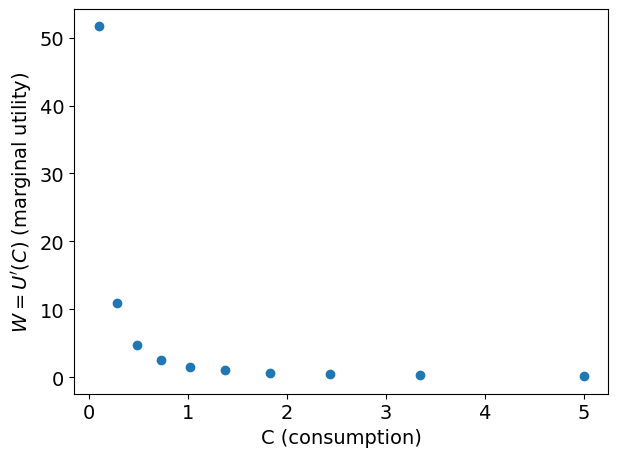

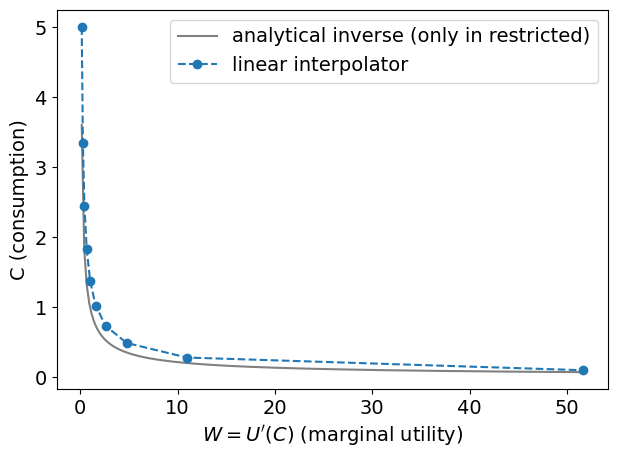

In [4]:
# illustrate the iEGM pre-computation
fig, ax = plt.subplots()
ax.scatter(par.grid_C,par.grid_marg_U)
ax.set(xlabel='C (consumption)',ylabel="$W=U\'(C)$ (marginal utility)");
fig.tight_layout()

fig, ax = plt.subplots()
fine_grid = np.linspace(par.grid_marg_U_flip[0],par.grid_marg_U_flip[-1],200)
ax.plot(fine_grid,model.inv_marg_HH_util(fine_grid),color='gray',label='analytical inverse (only in restricted)')
ax.plot(par.grid_marg_U_flip,par.grid_C_flip,marker='o',linestyle='--',color='tab:blue',label='linear interpolator');
ax.set(xlabel='$W=U\'(C)$ (marginal utility)',ylabel="C (consumption)");
ax.legend();
fig.tight_layout()

## Solve the "true" model using many grid points in VFI

In [5]:
test_specs = {
    'method': 'vfi',
    'restricted_model':False,
    
    'num_m': 200,
    'num_C':50,
    
}


In [6]:
# solve models with different approaches
models = dict()
for restricted in (True,False):
    restricted_str = 'unrestricted model' if not restricted else "restricted model"
    print(f'***** {restricted_str} *****')
    for method in ('vfi','egm','iegm'):
        for precomputed in (False,True):
            precomputed_str = '' if not precomputed  else ' (precomputed intra)'
            if (method=='egm') & (not restricted):
                continue
            # if (method != 'iegm') & (precomputed):
            #     continue
            print(method+precomputed_str)
            models[method] = UnitaryModelClass(par={**test_specs,'method':method,'restricted_model':restricted,'precompute_intra':precomputed})
            %time models[method].solve()
            print('\n',end='')

***** restricted model *****
vfi
CPU times: total: 2.59 s
Wall time: 2.51 s

vfi (precomputed)
CPU times: total: 2.62 s
Wall time: 2.51 s

egm
CPU times: total: 15.6 ms
Wall time: 21.4 ms

egm (precomputed)
CPU times: total: 31.2 ms
Wall time: 24.5 ms

iegm
CPU times: total: 31.2 ms
Wall time: 27 ms

iegm (precomputed)
CPU times: total: 15.6 ms
Wall time: 23.7 ms

***** unrestricted model *****
vfi
CPU times: total: 37.9 s
Wall time: 37.9 s

vfi (precomputed)
CPU times: total: 2.72 s
Wall time: 2.66 s

iegm
CPU times: total: 18.3 s
Wall time: 18.3 s

iegm (precomputed)
CPU times: total: 297 ms
Wall time: 307 ms



In [ ]:
# why is the precompute_intra so important? Also for iEGM? is it the last-period and the calculation after finding Ctot in general?

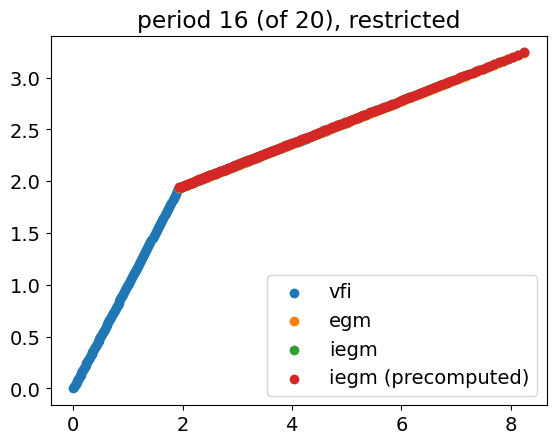

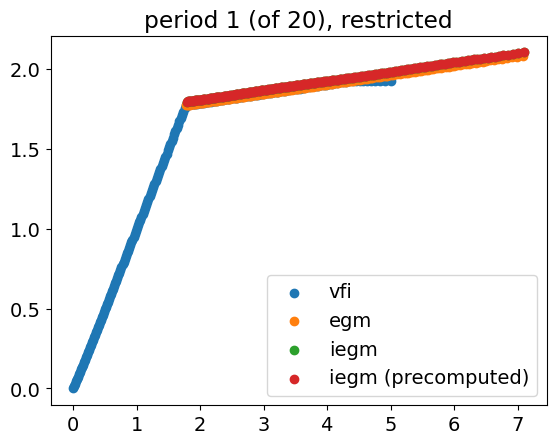

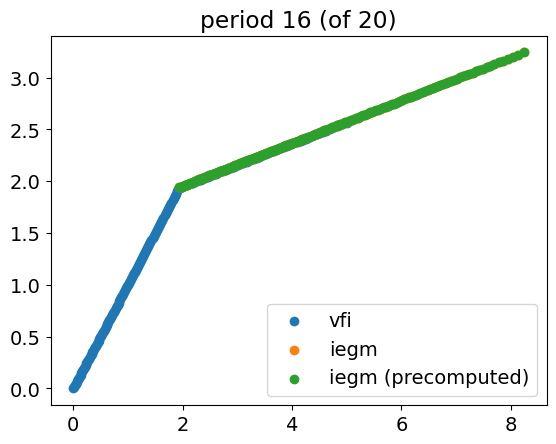

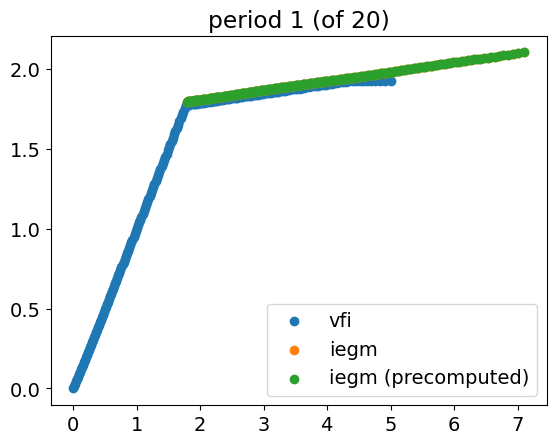

In [7]:
for restricted in (True,False):
    restricted_str = '' if not restricted else ", restricted"
    for t in (-5,-20):
        fig,ax = plt.subplots()
        for method in ('vfi','egm','iegm'):
            for precomputed in (False,True):
                precomputed_str = '' if not precomputed  else ' (precomputed)'
                if (method=='egm') & (not restricted):
                    continue
                if (method != 'iegm') & (precomputed):
                    continue
                ax.scatter(models[method].sol.M[t,:],models[method].sol.C[t,:],label=method+precomputed_str)
            ax.legend();
            ax.set(title=f'period {models[method].par.T+t+1} (of {models[method].par.T})'+restricted_str);

In [8]:
stop
# all the monte carlo stuff is not implemented yet.

NameError: name 'stop' is not defined

In [ ]:
# model_true = UnitaryModelClass({par=**true_specs'num_m:300})
# model_true.solve()

Monte Carlo Runs

In [ ]:
PRINT = False
# setup Monte Carlo results containers
timing = {
    'vfi':np.nan + np.zeros(MC_num),
    'egm':np.nan + np.zeros(MC_num),
    'egm, numerical':np.nan + np.zeros(MC_num),

    'iegm, linear':dict(),
    'iegm, linear inverse':dict(),
    
}
error = {
    'vfi':np.nan + np.zeros(MC_num),
    'egm':np.nan + np.zeros(MC_num),
    'egm, numerical':np.nan + np.zeros(MC_num),

    'iegm, linear':dict(),
    'iegm, linear inverse':dict(),
}
util = {
    'vfi':np.nan + np.zeros(MC_num),
    'egm':np.nan + np.zeros(MC_num),
    'egm, numerical':np.nan + np.zeros(MC_num),
    
    'iegm, linear':dict(),
    'iegm, linear inverse':dict(),
}
for i_c,num_C in enumerate(C_num_grid):
    timing['iegm, linear'][num_C] = np.nan + np.zeros(MC_num)
    error['iegm, linear'][num_C] = np.nan + np.zeros(MC_num)
    util['iegm, linear'][num_C] = np.nan + np.zeros(MC_num)

    timing['iegm, linear inverse'][num_C] = np.nan + np.zeros(MC_num)
    error['iegm, linear inverse'][num_C] = np.nan + np.zeros(MC_num)
    util['iegm, linear inverse'][num_C] = np.nan + np.zeros(MC_num)

# loop over Monte Carlo simulations
for i_mc in range(MC_num):
    if PRINT: print(f'{i_mc+1}/{MC_num} running...')
    # simulate true model (solved once above)
    model_true.par.seed = i_mc
    model_true.allocate_draws()
    model_true.simulate()
    true_mean_lifetime_util = model_true.sim.mean_lifetime_util

    # setup alternative model solutios
    model = BufferStockModelClass(par=specs)
    model.par.seed = i_mc
    model.allocate()

    # VFI and EGM
    for method in ['vfi','egm']:
        model.par.method = method
        
        # Timing
        t0 = time()
        model.solve()
        timing[model.par.method][i_mc] = time() - t0

        # Accuracy
        model.simulate()
        error[model.par.method][i_mc] = model.sim.mean_log10_euler
        util[model.par.method][i_mc] = np.abs((model.sim.mean_lifetime_util - true_mean_lifetime_util)/true_mean_lifetime_util) * 100

    # iEGM
    model.par.method = 'iegm'
    for interp_method in ('linear',):
        for interp_inverse in (False,True):
            model.par.interp_method = interp_method
            model.par.interp_inverse = interp_inverse
            method = f'{model.par.method}, {interp_method} inverse' if interp_inverse else f'{model.par.method}, {interp_method}'
            for i_c,num_C in enumerate(C_num_grid):
                model.par.num_C = num_C
                model.allocate()

                # Timing
                t0 = time()
                model.solve()
                timing[method][num_C][i_mc] = time() - t0

                # Accuracy
                model.simulate()
                error[method][num_C][i_mc] = model.sim.mean_log10_euler
                util[method][num_C][i_mc] = np.abs((model.sim.mean_lifetime_util - true_mean_lifetime_util)/true_mean_lifetime_util) * 100

    model.par.interp_method = 'numerical'
    model.par.interp_inverse = False
    method = f'egm, {model.par.interp_method}'
    # Timing
    t0 = time()
    model.solve()
    timing[method][i_mc] = time() - t0

    # Accuracy
    model.simulate()
    error[method][i_mc] = model.sim.mean_log10_euler
    util[method][i_mc] = np.abs((model.sim.mean_lifetime_util - true_mean_lifetime_util)/true_mean_lifetime_util) * 100


In [ ]:
print('lifetime util & Timing (rel. to VFI)')
timing_vfi = np.mean(timing['vfi'])
for method in ('vfi','egm','egm, numerical'):
    util_now = np.mean(util[method])
    time_now = np.mean(timing[method]) / timing_vfi
    print(f'{method}: {util_now:2.3f} & {time_now:2.3f} ')

for method in ('iegm, linear','iegm, linear inverse'):
    print(f'{method}: ')
    for i_c,num_C in enumerate(C_num_grid):
        util_now = np.mean(util[method][num_C]) 
        time_now = np.mean(timing[method][num_C]) / timing_vfi
        print(f'{num_C:d} {util_now:2.3f} & {time_now:2.3f} ')